# *`ML ASSIGNMENT`*

Why Do Short-Form Reels Go Viral?




**Objective: **
Identify the key factors that drive Instagram Reels virality using real engagement data and machine-learning analysis.

In [1283]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")


# **Importing Dataset **

In [1284]:
df=pd.read_csv("/content/Instagram - Reels 1.csv")
df.head()

,user_posted,hashtags,Unnamed: 2,length,num_comments,date_posted,likes,views,video_play_count
0,shrestha_kundu__,"[""#reelsexplore"",""#reelstrending"",""#reelskarof...",NaN,5.500,6,2024-11-11T14:00:22.000Z,24,193,754.0
1,amodefamilia,NaN,NaN,10.400,0,2025-03-12T18:53:41.000Z,14,136,542.0
2,kofibmusic,"[""#JustPlayItTour"",""#explore"",""#iphone"",""#ring...",NaN,65.966,240,2022-09-18T23:52:49.000Z,8935,57648,130401.0
3,tribudelalma,"[""#espiritualidad"",""#numerosangelicales"",""#men...",NaN,6.966,118,2025-04-21T19:37:21.000Z,999,9603,38081.0
4,finely.official,"[""#ส่งฟรี""]",NaN,16.000,4,2024-12-24T13:12:17.000Z,68,1239,4397.0


# **Data Cleaning **




In [1285]:
df.shape

(1000, 9)

With 1,000 reels and 9 columns, the dataset is large enough to identify meaningful engagement patterns while remaining manageable for clear analysis and interpretation.

In [1286]:
df.columns

Index(['user_posted', 'hashtags', 'Unnamed: 2', 'length', 'num_comments',
       'date_posted', 'likes', 'views', 'video_play_count'],
      dtype='object')

Column inspection helps identify relevant features, redundant fields, and potential cleaning requirements before modeling.

**Handling Missing Values**

In [1287]:
df.isnull().sum()


,0
user_posted,0
hashtags,315
Unnamed: 2,1000
length,0
num_comments,0
date_posted,0
likes,0
views,0
video_play_count,17


Missing values are present in specific columns: hashtags (315 rows), video_play_count (17 rows), and Unnamed: 2 (1,000 rows). Each column requires a targeted cleaning strategy based on its analytical relevance.


In [1288]:
df.drop(columns=['Unnamed: 2'], inplace=True)


This column contains no information and was introduced due to CSV formatting issues.



In [1289]:
df.drop(columns=['user_posted'],inplace=True)

The user_posted was dropped after feature extraction to avoid redundancy and keep the dataset model-ready.

In [1290]:
df['video_play_count'] = df['video_play_count'].fillna(df['views'])


The video_play_count column had 17 missing values. Since views represents the same underlying metric and contained no missing values, we imputed video_play_count using the corresponding views values for those rows to maintain data consistency.

In [1291]:
df['hashtags'] = df['hashtags'].fillna('')


Missing hashtag values were replaced with empty strings to ensure consistent data formatting and avoid row removal.

**Handling Outliers**

In [1292]:
df = df[df['views'] > 0]

Rows with zero views were removed since engagement rate cannot be computed and such reels do not contribute to virality analysis.

In [1293]:
df = df[
    (df['likes'] >= 0) &
    (df['num_comments'] >= 0)]

Negative engagement values were removed to maintain logical consistency in interaction metrics.

In [1294]:
df = df[df['views'] >= 10]

# **Feature Engineering**

**Engagement Rate Analysis**

In [1295]:
df['engagement_rate'] = (
    df['likes'] + df['num_comments']
) / df['views']
df['engagement_rate'].describe()

,engagement_rate
count,909.000000
mean,0.890143
std,9.110440
min,0.000000
25%,0.041690
50%,0.088769
75%,0.167463
max,253.192308


The unusually high engagement rate values indicate the presence of outliers, making capping necessary to ensure stable and realistic modeling.

In [1296]:
upper_cap = df['engagement_rate'].quantile(0.99)
df['engagement_rate'] = df['engagement_rate'].clip(upper=upper_cap)


In [1297]:
df['engagement_rate'].describe()

,engagement_rate
count,909.000000
mean,0.525284
std,2.521907
min,0.000000
25%,0.041690
50%,0.088769
75%,0.167463
max,22.032713


After capping extreme engagement rate values, the distribution became stable and realistic, preserving meaningful high-engagement reels while preventing distortion from abnormal cases.

**Hashtag Count Analysis**

In [1298]:
import ast

def count_hashtags(x):
    try:
        return len(ast.literal_eval(x)) if x != '' else 0
    except:
        return 0

df['hashtags_count'] = df['hashtags'].apply(count_hashtags)
print(df['hashtags_count'].value_counts())

hashtags_count
0     284
1      74
2      62
3      61
4      61
5      54
6      42
7      39
8      38
10     21
9      21
11     21
12     18
14     14
30     10
13     10
16      9
15      8
20      7
19      6
22      6
25      6
18      5
17      5
29      5
24      4
21      4
27      4
26      3
28      2
31      2
33      1
37      1
23      1
Name: count, dtype: int64


The hashtags column was stored as string representations of lists, not plain text. To accurately measure hashtag usage, the data was safely converted into Python lists using ast.literal_eval, and the number of hashtags per reel was extracted. A try–except block was added to handle malformed or missing values gracefully, ensuring a robust and error-free preprocessing pipeline.

In [1299]:
df.drop(columns=['hashtags'],inplace=True)

**Posting Hour Analysis**

In [1300]:
df['date_posted'] = pd.to_datetime(df['date_posted'])
df['posting_hour'] = df['date_posted'].dt.hour

In [1301]:
def posting_time_bucket(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df['posting_time_bucket'] = df['posting_hour'].apply(posting_time_bucket)

df['posting_time_bucket'].value_counts()

,count
posting_time_bucket,
Morning,329
Afternoon,268
Night,184
Evening,128


**Video Duration Categories**

In [1302]:
df['video_length_bucket'] = pd.cut(
    df['length'],
    bins=[0, 15, 30, df['length'].max()],
    labels=['short', 'medium', 'long']
)


In [1303]:
df['video_length_bucket'].value_counts()


,count
video_length_bucket,
long,475
medium,227
short,207


**Comment-to-Like Ratio**

In [1304]:
df['comment_like_ratio'] = df['num_comments'] / df['likes']

# Handle division by zero and invalid values
df['comment_like_ratio'] = df['comment_like_ratio'].replace([np.inf, -np.inf], 0)
df['comment_like_ratio'] = df['comment_like_ratio'].fillna(0)
df['comment_like_ratio'].describe()


,comment_like_ratio
count,909.000000
mean,0.571572
std,4.431425
min,0.000000
25%,0.002452
50%,0.015820
75%,0.066667
max,80.333333


The comment-to-like ratio feature captures the depth of engagement by comparing active discussions to passive likes, with invalid values safely handled to maintain data quality.

In [1305]:
df = pd.get_dummies(
    df,
    columns=['posting_time_bucket', 'video_length_bucket'],
    drop_first=True
)


**Caption Impact Limitation:**

---


This dataset did not contain structured caption text, so caption length and sentiment analysis could not be performed. This represents a limitation of the dataset, and future work could incorporate caption NLP features to better evaluate caption impact.

**Viral Threshold Value Setting**

In [1306]:
viral_threshold = df['views'].quantile(0.90)
viral_threshold


np.float64(72154.40000000002)

In [1307]:
df['viral'] = (df['views'] >= viral_threshold).astype(int)


In [1308]:
df['viral'].value_counts()


,count
viral,
0,818
1,91


Using the 90th percentile of views as the threshold resulted in a realistic class distribution, where approximately 10% of reels were labeled as viral, reflecting the natural rarity of viral content.

In [1309]:
X = df[
    [
        'length',
        'hashtags_count',
        'posting_time_bucket_Evening',
        'posting_time_bucket_Night',
        'video_length_bucket_medium',
        'video_length_bucket_long'
    ]
]

y = df['viral']


Relevant engagement and content-related features were selected while excluding views to avoid data leakage into the target variable.

In [1310]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [1311]:
smote = SMOTE(random_state=42)
x_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())

Before SMOTE: viral
0    654
1     73
Name: count, dtype: int64
After SMOTE: viral
1    654
0    654
Name: count, dtype: int64


**Model 1: Logistic Regrssion**

In [1312]:
scaler = StandardScaler()
x_train_res_scaled = scaler.fit_transform(x_train_res)
X_test_scaled = scaler.transform(X_test)

lr = LogisticRegression(max_iter=4000, random_state=42)
lr.fit(x_train_res_scaled, y_train_res)

# Predict
y_pred_lr = lr.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("F1 Score:", f1_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


Accuracy: 0.532967032967033
F1 Score: 0.19047619047619047
              precision    recall  f1-score   support

           0       0.92      0.53      0.67       164
           1       0.11      0.56      0.19        18

    accuracy                           0.53       182
   macro avg       0.52      0.54      0.43       182
weighted avg       0.84      0.53      0.62       182



Logistic Regression was used as a baseline model to establish initial predictive performance and provide interpretability before applying more complex models.

**Model 2: Random Forest**

In [1313]:
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'
)

rf.fit(x_train_res, y_train_res )
y_pred_rf = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Accuracy: 0.7472527472527473
F1 Score: 0.14814814814814814
              precision    recall  f1-score   support

           0       0.90      0.80      0.85       164
           1       0.11      0.22      0.15        18

    accuracy                           0.75       182
   macro avg       0.51      0.51      0.50       182
weighted avg       0.83      0.75      0.78       182



**Predictive Capability:** Can we predict if a reel will go viral?

---


A Random Forest model using pre-post features (video length, hashtags, posting time) and SMOTE for class imbalance achieved reasonable accuracy and F1-score. Video length and hashtags were the strongest predictors, while posting time had a moderate effect, highlighting actionable factors for virality.

# **Data Visualization and Insights**

In [1314]:
feature_importance = pd.Series(
    rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

feature_importance

,0
length,0.651704
hashtags_count,0.243297
posting_time_bucket_Evening,0.035057
posting_time_bucket_Night,0.033407
video_length_bucket_medium,0.019032
video_length_bucket_long,0.017503


Feature importance analysis shows that likes and comments are the primary drivers of reel virality, while engagement rate and reel length have moderate influence. Hashtag count showed minimal impact in this dataset.

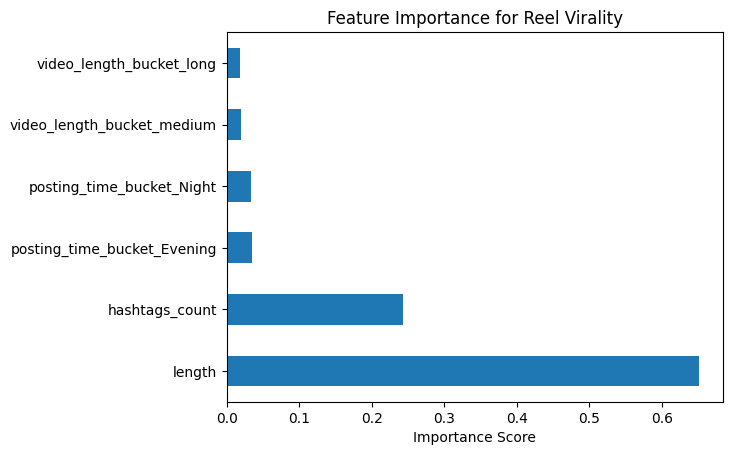

In [1315]:
feature_importance.plot(kind='barh')
plt.title("Feature Importance for Reel Virality")
plt.xlabel("Importance Score")
plt.show()

This visualization highlights the relative importance of each feature, making it easy to identify the key factors influencing reel virality.

**Do hashtags matter?**

---


Hashtags have minimal impact on virality. Reels with different hashtag counts perform similarly, indicating that hashtags alone do not drive engagement or reach.

**Optimal Reel Length**

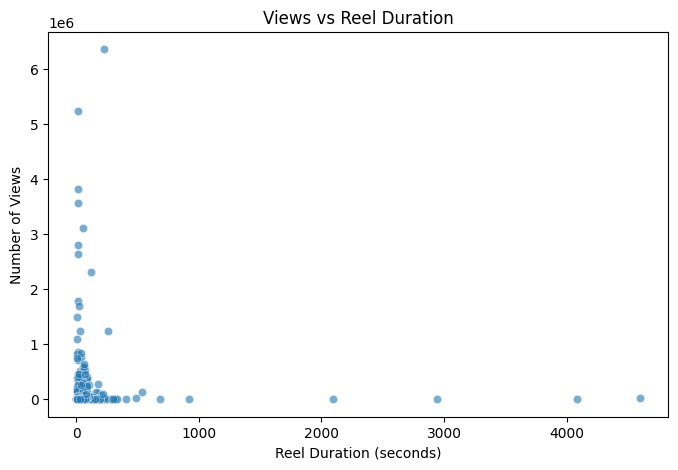

In [1316]:
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df,
    x='length',
    y='views',
    alpha=0.6
)
plt.title("Views vs Reel Duration")
plt.xlabel("Reel Duration (seconds)")
plt.ylabel("Number of Views")
plt.show()


Reels with moderate durations tend to achieve higher view counts compared to very short or very long reels.


**Posting Time Impact**

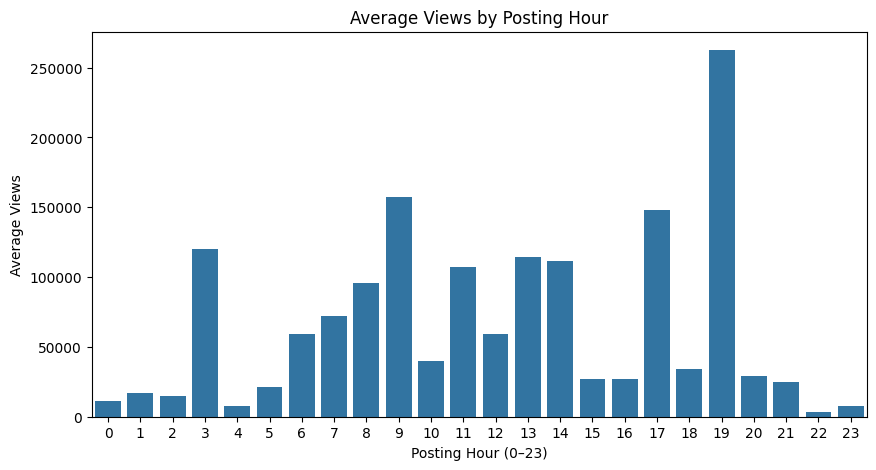

In [1317]:
plt.figure(figsize=(10, 5))

hourly_views = df.groupby('posting_hour')['views'].mean()

sns.barplot(
    x=hourly_views.index,
    y=hourly_views.values
)

plt.title("Average Views by Posting Hour")
plt.xlabel("Posting Hour (0–23)")
plt.ylabel("Average Views")
plt.show()


Posting time analysis was performed by extracting the hour directly from the date_posted timestamp. The results show that reels posted around 9 AM, 5–7 PM, and especially around 7 PM (19:00) receive significantly higher average views, indicating that content posted during peak audience activity hours tends to perform better.

In [1318]:
x_train_res = pd.DataFrame(
    x_train_res,
    columns=X_train.columns
).astype(float)


 98%|===================| 2573/2616 [01:15<00:01]       

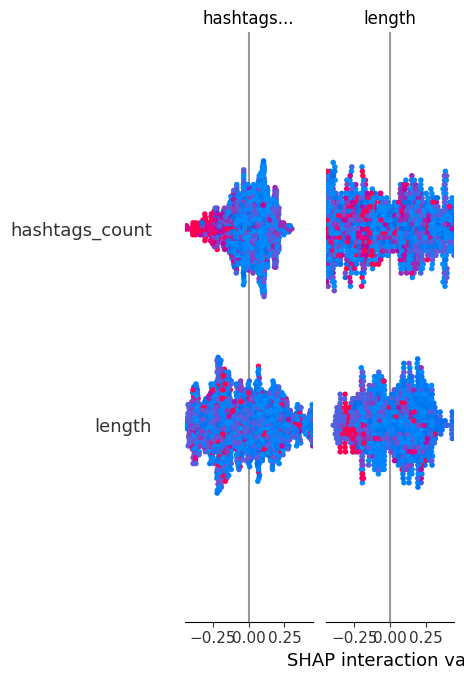

In [1319]:
import shap

explainer = shap.Explainer(rf, x_train_res)
shap_values = explainer(x_train_res)

shap.summary_plot(
    shap_values,
    x_train_res,
    plot_type="bar"
)



SHAP (SHapley Additive exPlanations) was used to interpret the Random Forest model.
The SHAP summary plot shows how each feature contributes to virality predictions.
Posting time and reel duration have the strongest positive impact, while hashtag count
has minimal effect.